# Section II. MODELING

Chapter 4. 3D Rotations
===============================

<style>
div.figcaption {    
    text-align:center;
    margin-left:1em;
    margin-top:1em;
    margin-right:1em;
    margin-bottom:1em;
    }
</style>

Although the previous chapter discussed how three-dimensional rotations
in SO(3) can be represented as 3x3 matrices, this is not usually the
most convenient representation. There are a number of alternative
rotation representations in frequent use in robotics, aviation, CAD,
computer vision, and computer graphics. Although SO(3) is a
3-dimensional space, it is fundamentally distinct from Cartesian space
in a *topological* sense, meaning that elements of the space of rotation
do not "connect" in the same way that normal points in space do. In this
chapter we will discuss the meaning of rotation matrices in more detail,
as well as the common representations of Euler angles, angle-axis form
and the related rotation vector form, and quaternions.

Each representation, in some sense, equivalent, since each may be mapped
to a rotation transform; however, certain representations are more
convenient for certain tasks, like inversion, composition,
interpolation, and sampling. All representations have some weaknesses as
well, and there is no "ideal" rotation representation. We will also
discuss how to represent continuous changes of rotation, and to
calculate derivatives.

Topology primer: rotations in 2D
--------------------------------

Not only is it relatively difficult to visualize 3D rotations compared
to translations, rotations behave in a fundamentally different fashion
than translations. To get a better understanding of rotations, we will
first introduce little bit of *topology*, a branch of mathematics that
studies how spaces are connected. Topological connectivity properties
are preserved under arbitrary invertible transformations, and hence they
are fundamental characteristics of the spaces themselves, and not simply
their coordinate representations.


We will start by introducing topological concepts in terms of the space
of 2D rotations SO(2). The immediate concern that one may have about 2D
rotations is that angles "wrap around," so that the direction at
$0^\circ$ is identical to $360^\circ$ or any multiple thereof. This is
an important issue in many contexts:

-   For a robot to rotate from a heading of $30^\circ$ to $330^\circ$,
    it is faster to rotate the $60^\circ$ CW rather than the $300^\circ$
    CCW.

-   If a joint has greater than a $360^\circ$ range of motion, then its
    internal position at a given time can only be measured externally
    modulo $360^\circ$: to estimate absolute position using external
    means, the history of all the joint's movements must be remembered.

-   When retrieving items from a table (of control commands or motions,
    for example) indexed by an angle, one must be careful to retrieve
    the closest item in terms of absolute angular deviation modulo
    $360^\circ$ rather than simply taking the absolute difference.

Although there is a one-to-one mapping between each element of SO(2) and
an angle in the interval $[0,2\pi)$, the "wrap around" issue illustrates
that SO(2) is fundamentally not equivalent because its elements do not
*behave* like numbers on the interval when discussing continuity and
proximity, as shown in [Fig. 1](#fig:TopologyRotation2D).

***************

![fig:TopologyRotation2D](figures/modeling/topology_rotation_2d.png)

<div class="figcaption"><a name="fig:TopologyRotation2D">Figure 1</a>. Top: The topology of the
space of 2D rotations is homeomorphic to a
circle, but not an interval. Although there is a one-to-one mapping
between points on the circle and the half-open interval $[0,2\pi)$, the
discontinuity at $2\pi$ makes them topologically distinct. Bottom: The
shortest path between the two marked points on the circle (solid arrow)
wraps around $2\pi$, which is a discontinuous path on the interval. The
shortest continuous path on the interval (dashed arrow) results in a
longer path on the circle.</div>

***************

### Basics concepts in topology

The topology of a space describes the connectedness of paths through it.
Paths in a space $\mathcal{X}$ are continuous functions
$x(s) : [0,1] \rightarrow \mathcal{X}$. Two spaces are topologically
equivalent if there exists a bijection between them that preserves path
continuity. Such a bijection is called a *homeomorphism*, and
topologically equivalent spaces called *homeomorphic*. If there exists
no such bijection, they are topologically distinct (not homeomorphic).

Since any mapping between SO(2) and $[0,2\pi)$ breaks the continuity of
paths through the 0 angle, they are topologically distinct. It can be
shown, however, that SO(2) is homeomorphic to the unit circle $S_1$. The
function mapping an angle $\theta$ to the point
$(\cos \theta, \sin \theta)$ on the circle (i.e., the direction vector
with heading $\theta$) is a bijection. The inverse mapping is an
operation known as the *argument* of the point, and is similar to
$\tan^{-1} (y/x)$ but respect the quadrant of each point $(x,y)$ and
also handles the case where $x=0$. (In many programming languages this
is given as a basic subroutine $atan2(y,x)$.) It can be shown that this
bijection preserves the continuity of paths through both SO(2) and
$S_1$: continuous paths on SO(2) map to continuous paths on $S_1$ and
vice versa, even if they pass through the 0 angle.

As a result, rotational motion is fundamentally similar to motion on a
circle. When interpolation is requested between two angles, what is
usually wanted is the *shortest* path between those angles. As a result,
rotational interpolation either requires specifying the direction of
rotation, or instead requires examining and minimizing the distance
traveled both CW and CCW.

### Geodesic distance and interpolation 

The path between two points in a space with minimum distance is known as
a *geodesic*. Geodesics are the most direct route between two points on
a space, and in Cartesian spaces are simply straight lines. The
*geodesic distance* is a function $d(x_1,x_2)$ giving the length of a
geodesic between two points. In more general topological spaces,
geodesics are often difficult to calculate, but there are closed form
solutions in SO(2) and SO(3).

We define the signed angular distance between two angles $\theta_1$ and
$\theta_2$ represented in the range $[0,2\pi)$ as the function:
$$diff(\theta_2,\theta_1) = \left\lbrace \begin{array}{ll} \theta_2 - \theta_1  & \text{if } -\pi < \theta_2 - \theta_1 \leq \pi \\
\theta_2 - \theta_1 - 2\pi & \text{if } \theta_2 - \theta_1 > \pi \\
\theta_2 - \theta_1 + 2\pi & \text{if } \theta_2 - \theta_1 \leq -\pi
\end{array} \right.$$
which results in a value in the range $(-\pi,\pi]$
that produces the angular displacement of $\theta_2$ from $\theta_1$
with minimum absolute value, and whose value is positive for CCW
displacement and negative for CW displacement.


The geodesic between two angles is an interpolation among the signed
angular distance:
$$\theta(s) = (\theta_1 + s \cdot diff(\theta_2,\theta_1)) \mod (2\pi).$$
The geodesic distance on $SO(2)$ is absolute angular distance, which is
simply the absolute value of the signed distance
$$d(\theta_1,\theta_2) = | diff(\theta_2,\theta_1) |.$$

## Representing elements of topological spaces

The most common topological spaces we discuss in robotics include:

- $\mathbb{R}^n$: Cartesian space of $n$ dimensions

- $SO(n)$: The special orthogonal group in $n$ dimensions.  This is defined as the set of $n \times n$ orthogonal matrices with determinant +1.  As we have seen before, SO(2) is the space of 2D rotations, and SO(3) is the space of 3D rotations.

- $SE(n)$: The special Euclidean group in $n$ dimensions.  This is the set of all rigid rotations in dimension $n$, and is equivalent to $SO(n) \times \mathbb{R}^n$.

- $S_n$: the $n$-dimensional sphere.  $S_1$ is the circle, and $S_2$ is the standard sphere.   It is important to note that this space denotes the _surface_ of the sphere, and $n$ is the _intrinsic dimensionality_ of the surface, even though we typically embed $S_1$ in a 2D plane, and $S_2$ in a 3D space.

It is also possible to compose multiple spaces with the Cartesian product, such as $S_1 \times S_1$, which is the topology of the torus.  We also use a power notation $S_1 \times S_1 = S_1^2$ to denote repeated applications of the Cartesian product.

Although we usually use a vector of parameters to describe elements of these spaces, this representation (in $\mathbb{R}^n$) does not capture their connectivity perfectly.  The vector representation will have deficiencies in having double representations of the same object, infinite representations of the same object (singularities), and in interpolation, which may not produce geodesics.

Let us first consider a simpler example that will illustrate several of the issues we will come across when representing 3D rotations.  The latitude and longitude representation of the unit sphere (spherical coordinates), where each point has coordinates $$\V{x}(\theta,\phi) = \begin{bmatrix} \cos \theta \cos \phi \\ \sin \theta \cos \phi \\ \sin \phi \end{bmatrix}.$$
Here $\theta \in [0,2\pi)$ gives the longitude and $\phi \in [-\pi/2,\pi/2]$ gives the latitude.

Since each point on the sphere can be represented by some $(\theta,\phi)$ pair, this shows that the inherent dimensionality of $S_2$ is no more than 2.
However, there are two singularities of this representation, namely, the north and south poles (0,0,1) and (0,0,-1), in which a point on the sphere have an infinite number of 2D representations. $\V{x}(\theta,\pi/2) = (0,0,1)$  for any value of $\theta$, and $\V{x}(\theta,-\pi/2) = (0,0,-1)$ for any value of $\theta$.

The nonlinearity in this mapping also means that as a point approaches and passes either pole, the representation of the point swings wildly.  If $\V{x} = (x,y,z)$, we have the inverse relation $\phi = \sin^{-1} z$, and $\theta = atan2(y,x)$ (which is undefined for $x=y=0$).  Observe the $\theta$ variable in the following plot as the arc gets closer to passing through the pole (blue and black curves):


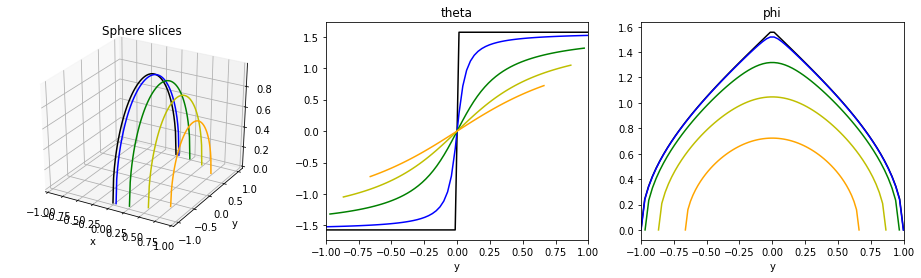

In [47]:
#Code for generating the spherical coordinates plot
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(16,4))
ax3d = fig.add_subplot(131, projection='3d')
axtheta = fig.add_subplot(132)
axphi = fig.add_subplot(133)

def plotyzcurve(x,**args):
    ymax = np.sqrt(1 - x**2)
    ys = np.linspace(-ymax,ymax,70)
    z2s = 1 - ys**2 - x**2
    z2s[0] = z2s[-1] = 0  #clean up numerical error
    zs = np.sqrt(z2s)
    ax3d.plot([x]*len(ys),ys,zs,**args)
    phi = np.arcsin(zs)
    theta = np.arctan2(ys,x)
    axtheta.plot(ys,theta,**args)
    axphi.plot(ys,phi,**args)
ax3d.set_xlim(-1,1)
ax3d.set_title("Sphere slices")
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
axtheta.set_xlim(-1,1)
axtheta.set_title("theta")
axtheta.set_xlabel('y')
axphi.set_xlim(-1,1)
axphi.set_title("phi")
axphi.set_xlabel('y')
plotyzcurve(0,color='k')
plotyzcurve(0.05,color='b')
plotyzcurve(0.25,color='g')
plotyzcurve(0.5,color='y')
plotyzcurve(0.75,color='orange')
plt.show()

Another limitation of this representation is that interpolation is not as straightforward as simply blending between two points.  Suppose two points $\V{a}$ and $\V{b}$ on the sphere are represented by spherical coordinates $(\theta_a,\phi_a)$ and $(\theta_b,\phi_b)$, respectively.  In general, the straight line path from $(\theta_a,\phi_a)$ and $(\theta_b,\phi_b)$ does not map to the shortest line between $\V{a}$ and $\V{b}$ on the sphere.  First of all, the connectivity between 0 and $2\pi$ in the $\theta$ dimension (that is, the topology of SO(2) in the domain of $\theta$) needs to be taken into account.  But even with that handled properly, these straight line paths are still not the shortest paths on the sphere &mdash; in other words, straight line interpolation in the representation space does not produce geodesic paths on the sphere.

You will have observed this phenomenon if you have ever taken an intercontinental flight between two destinations somewhat north of the equator. For example, the flight path from New York to London, when seen on a traditional map, is actually a curve that arcs above the straight line path from New York to London.  An even more extreme example is when flying from New York to Beijing: the flight path actually passes close to the North Pole!  Airlines are extremely sensitive to fuel usage, so they prefer to travel around the Earth along minimum length paths.  The mathematical solution to this problem is to interpolate along _great circles_, which are geodesics on the sphere.  Solving for and proving optimality of geodesics is of great interest, and as we shall see below, luckily there are closed-form solutions for geodesics in SO(3) as well.

3D rotation matrices
--------------------

Now let us return back to the 3D rotation case. As described before, 3D rotations
are $3\times 3$ matrices with the following entries: $$R = \begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33} 
\end{bmatrix}$$

There are 9 parameters in the matrix, but not all possible values of 9
parameters correspond to valid rotation matrices. To qualify as a
rotation, the matrix must satisfy the two properties:

1.  Orthogonality: $R^T R = I$ (or equivalently, $R R^T = I$)

2.  Positive orientation: $\det(R) = 1$.

The first condition imposes 9 equality constraints, except that 3 of
them are redundant. As a result, 6 degrees of freedom are removed from
the 9 free parameters, reducing the set of possible rotation matrices to
a 3-dimensional set. The second condition only reduces the set of valid
parameters by half, because all matrices that satisfy condition 1 must
have either determinant +1 or -1 (because the determinant is
distributive, $\det(AB) = \det(A)\det(B)$, and invariant to transpose,
$\det(A) = \det(A^T)$).

As a result, the space of 3D rotations is itself 3D, and hence *no fewer
than 3 continuous parameters are needed to represent all possible
rotations*. However, the topology of SO(3) is very different from
$\mathbb{R}^3$ in that it is bounded rather than infinite, and wraps
around "in all directions," so to speak.

### Axis-aligned rotations

Rotations about individual axes are the most straightforward to compute,
because the behavior of one axis is unchanged and the other two axes
undergo a 2D rotation along the orthogonal plane
([Fig. 2](#fig:AxisAlignedRotations)).

***************

![fig:AxisAlignedRotations](figures/modeling/axis_aligned_rotations.png)

<div class="figcaption"><a name="fig:AxisAlignedRotations">Figure 2</a>. Axis-aligned
rotations.</div>

***************

First, the matrix for rotation about the $Z$ axis contains a 2D rotation
matrix in its upper corner: $$R_Z(\theta) = \begin{bmatrix}
\cos \theta  & -\sin \theta   & 0 \\
\sin\theta  & \cos \theta   & 0 \\
0 & 0 & 1
\end{bmatrix}$$ This can be interpreted by imagining the $Z$ axis
pointing out of the page, and the $X$ and $Y$ axes marking the axes of a
standard graph on the page. The rotation about $\theta$ is a CCW
rotation in the plane of the page. Notice that the $Z$ coordinate of any
point is preserved by this operation, a property maintained by the third
row $(0,0,1)$, nor does it affect the $X$ and $Y$ coordinates, a
property maintained by the first two 0 entries of the third column. In
the $(X,Y)$ plane, the upper $2\times 2$ matrix is identical to a 2D
rotation matrix.

The rotation about the $X$ axis is similar, with a 2D rotation matrix
appearing along the $Y$ and $Z$ axes: $$R_X(\theta) = \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta  & -\sin \theta  \\
0 & \sin\theta  & \cos \theta   
\end{bmatrix}.$$ Here the $X$ coordinate is preserved while the $Y$
and $Z$ entries perform a 2D rotation.

Finally, the rotation about the $Y$ axis is similar, but with a sign
switch of the $\sin$ terms: $$R_Y(\theta) = \begin{bmatrix}
\cos \theta & 0 & \sin\theta \\
0 & 1 & 0\\
-\sin \theta & 0 & \cos \theta   
\end{bmatrix}.$$ The reason why the $-\sin \theta$ term switches to
below the diagonal is that if one were to orient a frame so the $Y$ axis
points out of the page, and align the $X$ axis to point rightward, the
$Z$ axis would point downward instead of upward. Instead, the matrix can
be derived by aligning the $Z$ axis to the rightward direction and the
$X$ axis to the upward direction, so that the $-\sin \theta$ term
arrives in the $Z,X$ spot. A mnemonic to help remember the sign switch
on rotations about $Y$ is that the order of the two coordinate
directions defining the orthogonal plane is derived from a *cyclic*
ordering of the axes: $Y$ follows $X$, $Z$ follows $Y$, and $X$ follows
$Z$. So, the plane orthogonal to $X$ is $(Y,Z)$, the plane orthogonal to
$Y$ is $(Z,X)$, and the plane orthogonal to $Z$ is $(X,Y)$.

### Interpretation

Suppose the rotation is such that the pre-rotation axes $X$, $Y$, and
$Z$, are rotated to post-rotation axes $X^\prime$, $Y^\prime$, and
$Z^\prime$, respectively. The first column represents the coordinates of
$X^\prime$ axis *relative to the original frame* after rotation
$$\V{x}^\prime = \begin{bmatrix} r_{11} \\ r_{21} \\ r_{31} \end{bmatrix}.$$ Similarly, the
second column gives $\V{y}^\prime = (r_{12},r_{22},r_{32})$ and the
third column gives $\V{z}^\prime = (r_{13},r_{23},r_{33})$.

Moreover, since $R^{-1} = R^T$, the coordinates of the old frame's axes
*relative to the new frame* are the individual rows of $R$.

Due to the cosine rule, $r_{11}$ is the cosine of the angle between the
old and new $X$ axis (because it is the dot product between
$\V{x}^\prime$ and $\V{x} = (1,0,0)$. Similarly, the other diagonal
elements give the cosine of the angle between the other axes.

### Operations

**Applying rotation to a point.** As we have seen before, applying
rotation to a point (i.e., deriving the coordinates of a rotated point
in the original coordinate frame) is simply matrix-vector
multiplication.

**Composition.** Composition between two rotation matrices $R_1$ and
$R_2$ is simple a matrix-matrix multiplication $R_1 R_2$. Note that this
matrix is the result of applying $R_2$ first and then $R_1$, and is not
the same as the converse.

**Inversion.** As we have seen above, the inverse rotation matrix is
simply the matrix transpose.

### Discussion

Properly composing rotations can be confusing due to the convention
chosen about whether rotation axes are considered fixed to the world
reference frame, or rotating along with the local reference frame. In
this class we will use the former convention, which is known as
*extrinsic* rotation. Suppose that $R_1$ is a rotation about axis $A$
and $R_2$ is a rotation about axis $B$. When composed to $R_1 R_2$, this
means that a point $P$ given in local coordinates $\V{p}$ will first get
rotated about axis $B$ to obtain a point $P^\prime$ and then about axis
$A$ *where $A$ is interpreted as being fixed in the un-rotated reference
frame* to obtain $P^{\prime\prime}$. The result $R_1 R_2 \V{p}$ gives
the coordinates of $P^{\prime\prime}$ relative to the un-rotated
reference frame, as shown in [Fig. 3](#fig:RotationComposition).

**************

![fig:RotationComposition](figures/modeling/rotation3d_composition.png)

<div class="figcaption"><a name="fig:RotationComposition">Figure 3</a>. The composition $R_1\cdot R_2$
of two rotation matrices corresponds to
first performing $R_2$, then performing $R_1$. This means that the
coordinate frame represented by $R_2$ is rotated about the axis of $R_1$
<i>in the original frame</i>.</div>

***************

The confusion often lies when axes of rotation are considered attached
to frames already being rotated (*intrinsic* rotations), which happens
when trying to solve problems like the following: "Let $P$ be attached
to a rigid body $B$ and have coordinates $(1,2,3)$ relative to $B$'s
coordinate frame. Find the world coordinates of the point after rotating
$B$ about its $Z$ axis by $90^\circ$, and then by another $90^\circ$
about $B$'s local $X$ axis, and finally translating its origin by the
offset $\V{t}(10,0,5)$."

Naïvely performing each transformation in sequence produces the wrong
answer:

1.  The rotation $R_Z(90^\circ)$ maps $(1,2,3)$ to $(-2,1,3)$.

2.  The rotation $R_X(90^\circ)$ maps $(-2,1,3)$ to $(-2,-3,1)$.

3.  The translation maps $(-2,-3,1)$ to $(8,-3,6)$.

This answer is incorrect, and is also the answer that would have been
obtained through composing the matrices:
$$R_X(90^\circ) R_Z(90^\circ) \V{p} + \V{t}$$ Instead, the key problem
is that after the first rotation, the local $X$ axis has rotated along
with the body, and is no longer equivalent to the $X$ axis in world
coordinates! Instead, it is aligned with the world's $Y$ axis. The
correct sequence of operations is:

1.  The rotation $R_Z(90^\circ)$ maps $(1,2,3)$ to $(-2,1,3)$.

2.  The rotation $R_Z(90^\circ)$ also maps the local $X$ axis to the
    world $Y$ axis.

3.  The rotation $R_Y(90^\circ)$ maps $(-2,1,3)$ to $(3,1,2)$.

4.  The translation maps $(3,1,2)$ to $(13,1,7)$.

It is also confusing that the correct result is also obtained by
switching the order of the rotations!
$$R_Z(90^\circ) R_X(90^\circ) \V{p} + \V{t}.$$ The reason why this
switched order works is that in the first rotation about $X$, the local
and world $X$ axis are aligned. The second rotation about $Z$ is
performed with respect to the world $Z$ axis, which is also equivalent
to $B$'s original $Z$ axis. In general, intrinsic rotations are composed
in reverse order to extrinsic rotations.

Euler angles
------------

Euler angles are a three-parameter representation of rotations
$(\phi,\theta,\psi)$, and are derived from the definitions of $R_X$,
$R_Y$, and $R_Z$ above. They are one of the oldest rotation
representations, are easy to interpret, and are also frequently used in
aeronautics and robotics. The basic idea is to select three different
axes and represent the rotation as a composite of three axis-aligned
rotations. The order in which axes are chosen is a matter of convention.

### Conventions

For example, the *roll-pitch-yaw* convention often used in aerospace
assumes that a vehicle's roll angle is about its $X$ axis, pitch is
about its $Y$ axis, and yaw is about its $Z$ axis
([Fig. 4](#fig:RollPitchYaw)), with the composite rotation given by:
$$R_{rpy}(\phi,\theta,\psi) = R_Z(\phi) R_Y(\theta) R_X(\psi)$$ Notice
that the order of rotation axes is $Z$, $Y$, $X$, and this is also known
as $ZYX$ convention. (Note that in order of application, this applies
roll (X) first, then pitch (Y), then yaw (Z).)

***************

![fig:RollPitchYaw](figures/modeling/roll_pitch_yaw.png)

<div class="figcaption"><a name="fig:RollPitchYaw">Figure 4.</a>
Roll-pitch-yaw convention consists of a roll about the vehicle's
forward direction, a pitch about its leftward direction, and a yaw
around its upward direction.</div>

***************

There are a multitude of other conventions possible, each of the form
$$R_{ABC}(\phi,\theta,\psi) = R_A(\phi) R_B(\theta) R_C(\psi)
\label{eq:EulerAngles}$$ where $A$, $B$, and $C$ are one of $X$, $Y$, or
$Z$. To be a valid convention, the span of possible results from the
convention must span the range of possible rotation matrices, and this
means that no two subsequent axes may be the same, e.g., $XXY$ is not
permissible, since two combined rotations about one axis are equivalent
to a single rotation about that axis. However, $A$ and $C$ may indeed be
the same, for example, in $ZYZ$ convention:
$$R_{ZYZ}(\phi,\theta,\psi) = R_Z(\phi) R_Y(\theta) R_Z(\psi)$$ Here the
intervening $Y$ rotation modifies the axis by which one of the $R_Z$
terms rotates, and can in fact span all rotation matrices.

### Conversion between matrices

Conversion from Euler angles to rotation matrices is a straightforward
computation of
($\ref{eq:EulerAngles}$). The converse is more challenging and
requires calculating the inverse of the forward conversion using some
trigonometry.

First, for the given convention we would begin by equating the matrix
terms to the sine and cosine terms of the computed rotation matrix,
e.g., for roll-pitch-yaw convention: $$R_{rpy} =  \begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33} 
\end{bmatrix} = \begin{bmatrix}
c_1 c_2  & c_1 s_2 s_3 - s_1 c_3 & s_1 s_3 + c_1 s_2 c_3 \\
s_1 c_2  & c_1 c_3 + s_1 s_2 s_3 &  s_1 s_2 c_3 - c_1 s_3 \\
- s_2    & c_2 s_3               & c_2 c_3  
\end{bmatrix}$$ where we use the shorthand $c_1 = \cos \phi$,
$c_2 = \sin \phi$, $c_2 = \cos \theta$, $s_2 = \sin \theta$,
$c_3 = \cos \psi$, and $s_3 = \sin \psi$.

The simplest term is in the lower left corner, so we find one of the two
solutions to $r_{31} = -\sin \theta$, namely
$\theta = - \sin^{-1} r_{31}$ or $\theta = - \sin^{-1} r_{31} + \pi$. We
also have two possible solutions $c_2 = \pm \sqrt{1 - s_2^2}$. If $c_2$
is nonzero, then we can divide $r_{11}$ and r$_{21}$ by $c_2$ to obtain
$s_1$ and $c_1$, respectively, by which we can obtain $\phi$ via the
argument of $(s_1, c_1)$. Similarly, we may derive $\psi$ by dividing
$r_{32}$ and $r_{33}$ by $c_2$. Finally one of the two possible
solutions to $\theta$ can be obtained by verifying the solution to the
upper right entries of the matrix.

The other case to consider is when $c_2$ is zero, which indicates that
the pitch is $\pm \pi / 2$. If this is the case, then only $r_{31}$ and
the $2 \times 2$ entries in the upper right are nonzero. This
corresponds to a *singular* case in which infinite solutions for $\phi$
and $\psi$ exist. All of these solutions have $\phi + \psi$ equal to the
argument of $(-r_{12} / s_2 ,r_{22} / s_2)$.

### Singularities, aka gimbal lock

The minimal range of Euler angles $(\phi,\theta,\psi)$ to cover the span
of rotations is the set
$[0,2\pi) \times [-\pi/2,\pi/2] \times [0,2\pi)$. However, this set is
not topologically equivalent to SO(3). There are certain cases in which
a single rotation has an infinite number of solutions. For example, in
$ABA$ convention, any pure rotation about the $A$ axis can be
represented by Euler angles with $\theta=0$ but infinitely many values
of $\phi$ and $\psi$ with constant sum. In roll-pitch-yaw convention,
pitches of $\pm \pi/2$ align the roll and yaw axes, and hence when a
vehicle is pointed directly upward there are an infinite number of
solutions for $\phi$ and $\psi$.

Cases like this are known as *singular*. By analogy with the gimbal
mechanism which is a physical device with three rotating axes, *gimbal
lock*. Gimbals are devices often used in gyroscopes to measure 3D
orientation by means of a rapidly spinning mass which maintains its
absolute orientation as its cradle rotates. Gimbal lock manifests itself
when two axes of the mechanism become aligned, at which point the gimbal
readings become useless because most rotations of the cradle fail to
de-align the axes properly.

In calculations, singularities cause problems for conversions,
calculating derivatives, and interpolation.

### Inversion

The inverse of an Euler angle $(\phi,\theta,\psi)$ with convention $ABC$
is another set of Euler angles $(-\psi,-\theta,-\phi)$ with convention
$CBA$. This is quite convenient when an $ABA$ convention is used,
because the reverse convention is the same as the forward. However, when
$C \neq A$, finding the inverse Euler angles in the same convention is
much less convenient, because it requires conversion to matrix form and
then back to Euler angle form.

Axis-angle and rotation vector representations
----------------------------------------------

Another popular rotation representation is axis-angle form, which
represents a rotation matrix as a rotation of a given angle about a
given unit axis
([Fig. 5](#fig:AxisAngleRotation)). Perhaps it is a surprising fact
that every rotation can be represented in this form!

***************

![fig:AxisAngleRotation](figures/modeling/axis_angle_rotation.png)

<div class="figcaption"><a name="fig:AxisAngleRotation">Figure 5</a>. Any
    rotation matrix (bold) can be represented by a rotation of some angle about
    some axis.</div>

***************

Axis-angle representation uses a pair $(\V{a},\theta)$ where $\V{a}$ is
a unit 3D vector and $\theta$ is an angle in the range $[0,\pi]$, for a
total of 4 parameters. However, the constraint $\| \V{a} \| = 1$ removes
a degree of freedom, again spanning the 3-D space of rotations.

A related representation, which we call the *rotation vector* form
improves upon some of the deficiencies of axis-angle representation by
simply encoding the axis as the direction and the angle as the length of
a 3D vector $\V{m} = \theta \V{a}$. They are easy to convert between,
with $\theta = \| \V{m} \|$ and $\V{a} = \V{m} / \| \V{m} \|$ if
$\| \V{m} \| \neq 0$, or some arbitrary vector like $(1,0,0)$ otherwise.
The range of valid parameters is a closed ball of radius $\pi$. It
should be noted that the rotation vector representation has been
referred to many names in the literature, including Rodrigues
parameters, exponential coordinates, or angular velocity. (It will
become extremely useful when we discuss the derivative of rotation
matrices in the context of the angular velocity of rigid bodies.)

### Converting to rotation matrix

To convert from axis-angle form to rotation matrices, we use *Rodrigues'
formula*. The derivation of Rodrigues' formula starts by decomposing a
rotated point into its coordinate about the axis $\V{a}$ and its
coordinates about an orthogonal plane. The planar coordinates are then
rotated by a 2D rotation of angle $\theta$.

Any point $\V{p}$ can be decomposed into a sum of a component
$\V{p}_\parallel$ parallel to $\V{a}$ and a component $\V{p}_\perp$
orthogonal to $\V{a}$ such that $\V{p} = \V{p}_\parallel + \V{p}_\perp$.

$$\V{p}_\parallel = (\V{a} \cdot \V{p}) \V{a}$$
$$\V{p}_\perp = \V{p} - (\V{a} \cdot \V{p}) \V{a}$$

The rotation leaves $\V{p}_\parallel$ unchanged, and rotates the
$\V{p}_\perp$ component about the axis to a new vector
$\V{p}_\perp^\prime$, with a changed direction but an unchanged
magnitude.

To derive $\V{p}_\perp^\prime$ we establish a basis for the orthogonal
plane to $\V{a}$. One axis on this plane, call it $\V{u}$, is in the
direction of the cross product $\V{a} \times \V{p}$, which is nonzero as
long as $\V{p}_\perp \neq 0$. A second orthogonal axis, call it $\V{v}$,
is in the direction of a second cross product
$\V{a} \times (\V{a} \times \V{p})$. This is in fact an expression of
the negative direction of $\V{p}_\perp$:
$\V{p}_\perp = -\V{a} \times (\V{a} \times \V{p})$.

As a result, the coordinates of $\V{p}_\perp$ given these (non-unit)
axes are $(0,-1)$, so that post rotation, $\V{p}_\perp^\prime$ will have
coordinates $(\sin \theta, - \cos \theta)$. Projecting these coordiantes
back into the original space, we have
$$\V{p}_\perp^\prime = \sin \theta (\V{a} \times \V{p}) + \cos \theta \V{p}_\perp$$
Reconstructing the rotated point $\V{p}^\prime$, we obtain:
$$\V{p}^\prime = (\V{a} \cdot \V{p}) \V{a} + \sin \theta (\V{a} \times \V{p}) +  \cos \theta (\V{p} - (\V{a} \cdot \V{p}) \V{a}))$$
which is often rearranged to group terms:
$$\V{p}^\prime = \cos \theta \V{p} + \sin \theta (\V{a} \times \V{p}) + (1-\cos \theta) (\V{a} \cdot \V{p}) \V{a}.$$

Although this formula gives an expression for the transform, we can also
rearrange terms to express it as a matrix. We will use the cross-product
matrix notation
$$\hat{\V{v}} = \begin{bmatrix} 0 & -v_z & v_y \\ v_z & 0 & -v_x \\ -v_y & v_x & 0 \end{bmatrix}, \label{eq:CrossProductMatrix}$$
so called because
$\hat{\V{v}} \V{w} = \V{v} \times \V{w}$.

Hence we can express the term $\V{a} \times \V{p} = \hat{\V{a}} \V{p}$
as a matrix multiplication. Also, we can express the term
$\V{p} - (\V{a} \cdot \V{p}) \V{a} = - \V{a} \times (\V{a} \times \V{p}) = -\hat{\V{a}}^2 \V{p}$,

$$\begin{split}
\V{p}^\prime &= \cos \theta \V{p} + \sin \theta (\V{a} \times \V{p}) + (1-\cos \theta) (\V{a} \cdot \V{p}) \V{a} - \V{p}) + (1-\cos \theta) \V{p} \\
 &=\V{p} + \sin \theta \hat{\V{a}} \V{p} + (1-\cos\theta) \hat{\V{a}}^2 \V{p} \\
 &= (I + \sin \theta \hat{\V{a}} + (1-\cos\theta) \hat{\V{a}}^2 ) \V{p}
\end{split}$$ The parenthesized term is the rotation matrix
corresponding to the axis-angle representation:
$$R_{aa}(\V{a},\theta) = 
I + \sin \theta \hat{\V{a}} + (1-\cos\theta) \hat{\V{a}}^2.$$

For rotation vector representation we simply convert to axis-angle form
and use the formula above.
$$R_m(\V{m}) = R_{aa}(\V{m} / \| \V{m} \|, \| \V{m} \|)$$

### Converting from a rotation matrix

To convert back from a rotation matrix $R$ to axis-angle representation,
we can calculate the entries of $R_{aa}(\V{a},\theta)$ and invert the
equation to match the entries of $R$: $$R = \begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33} 
\end{bmatrix} = \begin{bmatrix}
\cos\theta  I + \sin \theta \hat{\V{a}} + (1-\cos\theta ) \V{a} \V{a}^T
\end{bmatrix}$$ where we have used the fact that $$\hat{\V{a}}^2 = 
\begin{bmatrix}
0 & -a_z & a_y \\
a_z & 0 & -a_x \\
-a_y & a_x  0
\end{bmatrix}^2 = \begin{bmatrix}
-a_z^2 - a_y^2 & a_x a_y & a_x a_z \\
a_x a_y & -a_x^2 - v_z^2 & a_y a_z \\
a_x a_z & a_y a_z & -a_x^2 - a_y^2
\end{bmatrix}
= \V{a} \V{a}^T - I.$$ Taking the trace of $R$, we get
$$tr(R) = 3 \cos \theta + (1-\cos \theta) tr(\V{a} \V{a}^T) = 3 \cos \theta + (1 - \cos\theta) (\V{a} \cdot \V{a}) = 1 + 2 \cos \theta.$$
Hence, we have the relationship:
$$\theta = \cos^{-1} \left(\frac{tr(R)-1}{2}\right)
\label{eq:RotationAbsoluteAngle}$$ which gives the *absolute angle* of a
rotation matrix. This is also significant because it is the minimal
angle needed to rotate from the identity matrix to $R$, and hence is a
useful pseudo-norm for 3D rotations.

Next, we can determine $\V{a}$ using the off-diagonal components of the
matrix. We see that the difference
$r_{12} - r_{21} = -a_z \sin \theta + (1-\cos \theta) a_x a_y - (a_z \sin \theta + (1-\cos \theta) a_x a_y) = -2 a_z \sin \theta$,
canceling out the contribution of the matrix $\V{a} \V{a}$ since it is
symmetric. Hence if $\sin \theta \neq 0$, we can determine
$$\begin{split}
a_x &=  (r_{32}-r_{23}) / 2 \sin \theta \\
a_y &=  (r_{13}-r_{31}) / 2 \sin \theta \\
a_z &=  (r_{21}-r_{12}) / 2 \sin \theta.
\end{split}$$ In the case where $\sin \theta = 0$, we could either have
the case where $\theta = 0$, in which case $R$ is an identity matrix and
any axis will do, or $\theta = \pi$, and more work is needed to
determine the true axis of rotation. In this case, $\cos \theta = -1$,
so $R = -I + 2 \V{a} \V{a}^T$. We can then determine, up to sign,
$a_x = \pm \sqrt{(r_{11} + 1)/2}$, $a_y = \pm \sqrt{(r_{22} + 1)/2}$,
and $a_z = \pm \sqrt{(r_{33} + 1)/2}$, with the signs of each element
(up to a sign of the entire vector) determined by the off-diagonal
components.

### Singularities

There are two singularities for axis-angle representation. The first is
at $\theta = 0$, where every axis represents the identity rotation. The
rotation vector representation does not have this singularity.

The second is at $\theta = \pi$, where each axis and its negation
represent the same rotation. This is a potential problem in
extrapolation or interpolation because further rotations flip the sign
of the axis. Both axis-angle and rotation vector representations share
the same singularity, and in the latter case, this means that opposed
points on the surface of the ball
$\{ \V{m}\in \mathbb{R}^3 \, |\, \|\V{m}\| \leq \pi \}$ represent
identical rotations.

Observe that the set of rotation vector representations that maps
one-to-one to SO(3) is a sort of "half-open, half-closed" ball in
$\mathbb{R}^3$. Like the rotation angle representation of a 2D rotation,
this set is not topologically equivalent to SO(3) due to the
wrapping-around effect.

### Inversion

One of the advantages of axis-angle representation is that inversion is
very simple. The inverse of a rotation $(\V{a},\theta)$ is simply
$(-\V{a},\theta)$, or, if negative rotations are allowed,
$(\V{a},-\theta)$. Equivalently, the inverse of a rotation vector
representation is simply its negative $R_m(\V{m})^{-1} = R_m(-\V{m})$.

### Geodesic scaling

One of the key advantages of axis-angle representation is that it
conveniently represents the geodesic curve from the identity rotation to
any given rotation. If $R_1$ is a given rotation matrix with axis-angle
form $(\V{a},\theta)$, then the geodesic interpolation from $I$ to $R_1$
is given by the curve $$R(s) = R_{aa}(\V{a},s\theta)$$ where at $s=0$
the result is the identity, and at $s=1$ the result is $R_1$.

### Geodesic interpolation

We apply the geodesic scaling operation to produce geodesic
interpolation between two rotations. Given an initial rotation $R_0$ and
a final rotation $R_1$, we may perform the interpolation
$$R(s) = R_0 R_{aa}(\V{a},s\theta)$$ where $(\V{a},\theta)$ is the axis
angle representation of the relative rotation $R_0^T R_1$. (Verify that
$R(0) = R_0$ and $R(1) = R_1$.)

Because of its common utility, it may be useful to consider representing this
procedure as a SO(3) geodesic subroutine $SO3interp(R_0,R_1,s)$.

Quaternions
-----------

Quaternions are also another convenient rotation representation based on
an extension of complex numbers. Unit complex numbers
$c = \cos \theta + i \sin \theta$ with $|c| = \sqrt{a^2 + b^2} = 1$ can
represent 2D rotations because complex multiplication performs rotation:
$$c (p + i q) = (p \cos \theta - q \sin \theta) + i (p \sin \theta + q \cos \theta)$$
where the real and imaginary components are respectively the $x$ and $y$
component of a point $(p,q)$ rotated by $\theta$. A long search in the
19th century to find analogues of complex numbers that could perform 3D
rotations yielded the quaternion representation.

Quaternions $(q_0,q_1,q_2,q_3)$ are composed of 1 real coordinate $q_0$
and three imaginary coordinates $q_1$, $q_2$, and $q_3$ that represent a
complex number $$q = q_0 + i q_1 + j q_2 + k q_3$$ where $i$, $j$, and
$k$ are imaginary numbers defined such that

-   $i^2 = j^2 = k^2 = -1$

-   $i = jk = -kj$

-   $j = ki = -ik$

-   $k = ij = -ji$.

Note that these multiplication rules are non-symmetric. The product of
two quaternions is a non-symmetric operation that is defined by applying
standard distributive laws and the above rules:
$$
\begin{split}
q p  = & (q_0 + i q_1 + j q_2 + k q_3) (p_0 + i p_1 + j p_2 + k p_3) \\
 = & q_0 (p_0 + i p_1 + j p_2 + k p_3) + i q_1 (p_0 + i p_1 + j p_2 + k p_3) + \\
   & j q_2  (p_0 + i p_1 + j p_2 + k p_3)+ k q_3 (p_0 + i p_1 + j p_2 + k p_3) \\
 = & q_0 p_0 + i q_0 p_1 + j q_0 p_2 + k q_0 p_3 + i q_1 p_0 + i^2 q_1 p_1 + i j  q_1 p_2 + i k  q_1 p_3 + \\
   & j q_2  p_0 + j i q_2 p_1 + j^2 q_2 p_2 + j k q_2 p_3 + k q_3 p_0 + k i  q_3 p_1 +  k j  q_3 p_2 + k^2  q_3 p_3 \\
 = & (q_0 p_0 - q_1 p_1 - q_2 p_2 - p_3 p_3) + i (q_0 p_1 + q_1 p_0 + q_2 p_3 - q_3 p_2) + \\
   & j (q_0 p_2 + q_2 p_0 - q_1 p_3 + q_3 p_1) + k (q_0 p_3 + q_3 p_0 + q_1 p_2 -  q_2 p_1)
\end{split}
\label{eq:QuaternionMultiplication}
$$ Norms are defined as usual so that
$|q| = \sqrt{q_0^2 + q_1^2 + q_2^2 + q_3^2} = 1$ defines a unit
quaternion. Unit quaternions have the special property that their
inverse is simply the negation of their imaginary components:
$q^{-1} = q_0 - i q_1 - j q_2 - k q_3$.

Given a 3D point $\V{p} = (x,y,z)$ and its representation as a
quaternion $p = (0,x,y,z)$, there is an operation called the
*conjugation* of $p$ by a unit quaternion $q$ so that the result gives a
rotated point $p^\prime = (0,x^\prime,y^\prime,z^\prime)$:
$$p^\prime = q p q^{-1}.$$ More specifically, the quaternion is related
to axis-angle representation $(\V{a},\theta)$ using the conversion
$(q_0,q_1,q_2,q_3) = ( \cos (\theta / 2), \sin (\theta / 2) a_x, \sin (\theta / 2) a_y, \sin (\theta / 2) a_z)$.
Also, the rotation matrix defined by a quaternion is given by:
$$R_q(q) = \left[\begin{array}{ccc}
2 (q_0^2 + q_1^2 ) - 1 & 2 (q_1 q_2 - q_0 q_3)  & 2 (q_1 q_3 + q_0 q_2) \\
2(q_1 q_2 + q_0 q_3 )  & 2 (q_0^2 + q_2^2 ) - 1 & 2 (q_2 q_3 - q_0 q_1) \\
2(q_1 q_2 - q_0 q_3 )  & 2 (q_2 q_3 + q_0 q_1)  & 2 (q_0^2 + q_3^2 ) - 1
\end{array}\right].$$

### Double cover of 4 sphere

Quaternions are similar to points on a 4-D unit sphere, but they have
the property that a quaternion and its negative produce equivalent
rotations. This can be easily seen from the conjugation equation:
$$p^\prime = q p q^{-1} = (-q) p (-q)^{-1}.$$ As a result, the space of
rotations could be thought of as a 4-D sphere except warped so that
points on the opposite sides of the sphere are mapped to the same
rotation. This representation makes certain operations, like
interpolation, somewhat more difficult to perform than on a sphere.

### Composition

Quaternions have slight advantages over rotation matrices when
performing rotation composition because quaternion products perform
composition. This operation requires 16 multiplications and 12 additions
/ subtractions in ($\ref{eq:QuaternionMultiplication}$) as compared to 27
multiplications and 18 additions for standard matrix multiplication.

### Geodesic interpolation

An operation called spherical linear interpolation, or "slerp," can be
used to perform geodesic interpolation of rotations using quaternions.
More generally it can be used to interpolate across great circles on
spheres of arbitrary dimension.

The process is as follows. Given two quaternions $q$ and $p$, the
operation first needs to figure out which sign of $p$ to assign in order
to choose the closer way around the 4-D sphere. Specifically, if the dot
product of $q$ and $p$, $q \cdot p$, is negative, then the sign of each
element of $p$ is flipped. (This step is specific to quaternion rotation
interpolation, and skipped for general slerp on spheres.)

Next, the angle $\theta$ between the two quaternions is computed
according to $\theta = \cos^{-1} (q \cdot p)$. Finally, the interpolated
quaternion is given by
$$r(s) = \frac{\sin ((1-s) \theta)}{\sin \theta} q + \frac{\sin (s \theta)}{\sin \theta} p.$$
It can be shown that this is a geodesic and interpolates across the
great circle at constant velocity.

Summary
-------

There is no ideal rotation representation for all purposes, and in some
sense, all are equivalent because each representation has an equivalent
rotation matrix representation. However, a choice must indeed be made
for calculations and coordinate conventions. To assist in this choice,
the table below is a "cheat sheet" that summarizes
all of the different rotation representations' advantages and
disadvantages.

<div class="figcaption"><a name="tab:RotationCheatSheet">Rotation cheat sheet</a></div>

| **Representation** | **Parameters** |
|:-------------------|:---------------|
|  Matrix              | $3\times 3$ matrix $R$ with 9 parameters, with 6 d.o.f. removed via orthogonality constraints. |
|  Euler angles:       | 3 parameters $(\phi,\theta,\psi)$, in range $[0,2\pi) \times [-\pi/2,\pi/2] \times [0,2\pi)$ |
|  Axis-angle          | 3 + 1 parameters $(\V{a},\theta)$, in range $S_2 \times [0,\pi)$ with 1 d.o.f. removed via unit vector constraint $\|V{a}\| = 1$. |
|  Rot. vector         | 3 parameters $\V{m}$, in range $\| \V{m} \| \leq \pi$. |
|  Quaternion          | 4 parameters $(q_0,q_1,q_2,q_3)$, with 1 d.o.f. removed via unit quaternion constraint. |
|  <span></span>       | **Singularities and multiple representations** |
|  Matrix              | None. |
|  Euler angles        | Singularities at $\theta = 0$ or $\theta = \pm \pi/2$, depending on convention. |
|  Axis-angle          | Singularities at $\theta = 0$ (all axes are equivalent) and $\theta = \pi$ (an axis and its negation are equivalent). |
|  Rot. vector         | Double representation at $\| \V{m} \| = \pi$. |
|  Quaternion          | Double representation $R_q(q) = R_q(-q)$ everywhere. |
|  <span></span>       | **Inversion** |
|  Matrix              | $R^T$ |
|  Euler angles        | $(-\psi,-\theta,-\phi)$ if using an $ABA$ convention. Otherwise, no straightforward formula. |
|  Axis-angle          | $(-\V{a},\theta)$ |
|  Rot. vector         | $-\V{m}$ |
|  Quaternion          | $(-q_0,q_1,q_2,q_3)$ |
|  <span></span>       | **Composition** |
|  Matrix              | matrix product $R_1 R_2$. |
|  Euler angles        | no straightforward formula. |
|  Axis-angle          | no straightforward formula. |
|  Rot. vector         | no straightforward formula. |
|  Quaternion          | quaternion multiplication. |


Interpolation for all representations can be performed by converting to
matrix form and performing geodesic interpolation using the axis-angle
method. Quaternions have a special interpolation method using spherical
linear interpolation (with care taken to pick closest dual
representation on 4-sphere).

Key takeaways:

-   2D and 3D rotations are important for modeling rigid body movement.

-   Rotation has fundamentally different topology from Cartesian space.
    Interpolation and distance is not the same as treating rotation
    representations as points in Cartesian space.

-   The four major representations of 3D rotations are rotation matrix,
    Euler angle (e.g., roll-pitch-yaw), axis-angle (which is very
    similar to the rotation vector representation), and quaternion.

-   All representations are somewhat equivalent in that they can be
    converted to a rotation matrix and back again. But each has some
    strengths and weaknesses.

-   Robotics and 3D visualization software packages should contain
    functions for converting between many of these representations.

Exercises
---------

1.  Derive a method to compute the "average" of two angles in SO(2).
    Hint: consider the interpolation formula. For what pairs of angles
    is the notion of average ill-defined?

2.  Is SO(3) equivalent to SO(2) $\times$ SO(2) $\times$ SO(2)? Why or
    why not?

3.  Explain why the 3D rotation about the Y axis has the signs of its
    off-diagonal $\sin \theta$ terms in the opposite orientation as the
    X and Z rotations.

4.  Give an example of an Euler angle representation for which direct
    interpolation produces a path of rotations that is very unlike a
    geodesic in SO(3).

5.  Symbolically, derive the function that maps a ZYZ Euler angle
    representation to a $3\times 3$ rotation matrix. Now, compute its
    inverse (that is, a procedure for mapping a rotation matrix to a ZYZ
    Euler angle representation). Where are the singularities of this
    representation?

6.  Derive a method to compute the average of two 3D rotation matrices.
    (Use the hint given in problem 1.)

7.  For the cross-product matrix function $\hat{\V{v}}$ given by
    ($\ref{eq:CrossProductMatrix}$), show that
    $R \hat{\V{v}} R^T = \hat{R\V{v}}$.

8.  Consider a distance function $d(R_A,R_B)$ between two matrices,
    defined as the absolute angle of $R_A^T R_B$ (as given by
    ($\ref{eq:RotationAbsoluteAngle}$)). Prove that it satisfies
    three conditions needed for being a metric: $d(R,R)=0$ iff $R=R$,
    $d(R_A,R_B)\geq 0$, $d(R_A,R_B)=d(R_B,R_A)$. Do you think it
    satisfies the triangle inequality
    $d(R_A,R_B) \leq d(R_A,R_C) + d(R_C,R_B)$ for all $R_C$? Why or why
    not? (Hint: consider what it means to be a geodesic)



## Interactive examples

The following interactive examples require Klampt-jupyter-extension and Klamp't to be installed on your system.  Instructions can be found at
[https://github.com/krishauser/Klampt-jupyter-extension](https://github.com/krishauser/Klampt-jupyter-extension)

### Comparing 3D rotation representations

Use the sliders to observe how the chosen parameters affect the corresponding rotation matrix.

Notes:

- The axis of axis-angle rotations is specified with spherical coordinates $(\phi,\psi)$

- The quaternion components $(q_0,q_1,q_2,q_3)$ are labeled $(q_w,q_x,q_y,q_z)$. The sliders let you change the $q_x, q_y, q_z$ components, while the $q_w$ component is given by $\sqrt{1 - q_x^2 - q_y^2 - q_z^2}$.

In [1]:
#Code for the interactive example (run me!)
import time
from klampt import *
from klampt.math import so3,vectorops
import math
from IPython.display import clear_output
import ipywidgets as widgets
import ipyklampt

world = WorldModel()
def make_frame_widget(name,size,opacity=1.0):
    x = world.makeRigidObject(name+"_x")
    y = world.makeRigidObject(name+"_y")
    z = world.makeRigidObject(name+"_z")
    x.geometry().loadFile("data/cube.off")
    y.geometry().loadFile("data/cube.off")
    z.geometry().loadFile("data/cube.off")
    w = size*0.1
    x.geometry().transform([size,0,0,0,w,0,0,0,w],[0,-w*0.5,-w*0.5])
    y.geometry().transform([w,0,0,0,size,0,0,0,w],[-w*0.5,0,-w*0.5])
    z.geometry().transform([w,0,0,0,w,0,0,0,size],[-w*0.5,-w*0.5,0])
    x.appearance().setColor(1,0,0,1)
    y.appearance().setColor(0,1,0,1)
    z.appearance().setColor(0,0,1,1)

def set_frame_widget_xform(name,T):
    world.rigidObject(name+"_x").setTransform(*T)
    world.rigidObject(name+"_y").setTransform(*T)
    world.rigidObject(name+"_z").setTransform(*T)
    
#euler angle variable
ea = [0,0,0]
#axis-angle variables
aa_params = [0,0,0]
#rotation vector variables
rv = [0,0,0]
#quaternion variables
quat = [0,0,0]

euler_translation = [-0.4,0,0.4]
aa_translation = [0.4,0,0.4]
vector_translation = [-0.4,0,-0.4]
quaternion_translation = [0.4,0,-0.4]
make_frame_widget("euler_rotation",0.3)
make_frame_widget("aa_rotation",0.3)
make_frame_widget("vector_rotation",0.3)
make_frame_widget("quaternion_rotation",0.3)

kvis = ipyklampt.KlamptWidget(world,width=350,height=350)
#zoom in a little
kvis.set_camera({u'near': 0.1, u'target': {u'y': 0.146443072460387, u'x': 0.08312657322959151, u'z': 0}, u'far': 1000, u'position': {u'y': 0.7493652567628877, u'x': 0.07405620728023105, u'z': 1.7117987931956757}, u'up': {u'y': 0.9921955328504627, u'x': -0.0023691959056403237, u'z': 0.12466920831683183}})

#define callbacks for interactive updates
def euler_update_cb(b):
    T = (so3.from_rpy((ea[2],ea[1],ea[0])),euler_translation)
    set_frame_widget_xform("euler_rotation",T)
    kvis.update()
def aa_update_cb(b):
    axis = (math.cos(aa_params[0])*math.cos(aa_params[1]),math.sin(aa_params[0])*math.cos(aa_params[1]),math.sin(aa_params[1]))
    T = (so3.from_axis_angle((axis,aa_params[2])),aa_translation)
    set_frame_widget_xform("aa_rotation",T)
    kvis.add_line("aa_axis",*(aa_translation + vectorops.madd(aa_translation,axis,0.3)))
    kvis.set_color("aa_axis",1,0.5,0)
    kvis.update()
def vector_update_cb(b):
    T = (so3.from_moment(rv),vector_translation)
    set_frame_widget_xform("vector_rotation",T)
    kvis.add_line("rv_axis",*(vector_translation + vectorops.madd(vector_translation,rv,0.2)))
    kvis.set_color("rv_axis",1,0.5,0)
    kvis.update()
def quaternion_update_cb(b):
    w = 1.0-vectorops.dot(quat,quat)
    if w < 0:
        w = 0
        q = [w] + vectorops.unit(quat)
    else:
        w = math.sqrt(w)
        q = [w]+quat
    T = (so3.from_quaternion(q),quaternion_translation)
    set_frame_widget_xform("quaternion_rotation",T)
    kvis.update()

#initialize the displays
euler_update_cb(None)
aa_update_cb(None)
vector_update_cb(None)
quaternion_update_cb(None)

#create the widgets
euler_widget = ipyklampt.EditPoint(value=ea,min=[0,0,0],max=[math.pi*2]*3,labels=['yaw','pitch','roll'],callback=euler_update_cb)
euler_widget = widgets.VBox([widgets.Label("Euler angles"),euler_widget])
aa_widget = ipyklampt.EditPoint(value=aa_params,min=[0,-math.pi/2,0],max=[math.pi*2,math.pi/2,math.pi],labels=['axis phi','axis psi','angle'],callback=aa_update_cb)
aa_widget = widgets.VBox([widgets.Label("Axis-angle"),aa_widget])
vector_widget = ipyklampt.EditPoint(value=rv,min=[-math.pi]*3,max=[math.pi]*3,labels=['x','y','z'],callback=vector_update_cb)
vector_widget = widgets.VBox([widgets.Label("Rotation vector"),vector_widget])
quaternion_widget = ipyklampt.EditPoint(value=quat,min=[-1]*3,max=[1]*3,labels=['qx','qy','qz'],callback=quaternion_update_cb)
quaternion_widget = widgets.VBox([widgets.Label("Quaternion (qw is implicit)"),quaternion_widget])

#show the grid
display(widgets.HBox([widgets.VBox([euler_widget,vector_widget]),kvis,widgets.VBox([aa_widget,quaternion_widget])]))

#use these displays instead, if the grid doesnt look good on your notebook
#display(kvis)
#display(widgets.HBox([euler_widget,aa_widget]))
#display(widgets.HBox([vector_widget,quaternion_widget]))


SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdFdWxlciBhbmdsZXMnKSwgVkJveChjaGlsZHJlbj0oRmxvYXRTbGlkZXIodmFsdWU9MC7igKY=
